In [1]:
%load_ext autoreload
%autoreload 2
%cd C:\MAD4AG
%matplotlib inline

C:\MAD4AG


In [2]:
import pandas as pd
import numpy as np
# from google.colab import drive
from tqdm import tqdm
from datetime import datetime
import matplotlib.pyplot as plt

In [3]:
df_survey = pd.read_csv('Master Thesis/Master Thesis Colab/DataFolder/survey_act_new.csv')


In [4]:
# Convert "act_start" and "act_end" columns to datetime objects


df_survey['act_start'] = pd.to_datetime(df_survey['act_start'])
df_survey['act_end'] = pd.to_datetime(df_survey['act_end'])

# Calculate the "dur" column*
df_survey['dur'] = (df_survey['act_end'] - df_survey['act_start']).dt.total_seconds() / 60  # Convert to hours

In [5]:
# Check for negative values in the "dur" column
negative_dur = df_survey[df_survey['dur'] < 0]

df_survey = df_survey.drop(df_survey[df_survey['sub_id'].isin(negative_dur['sub_id'].unique())].index)

In [6]:
mapping = {0: 'Home', 2: 'Work', 3: 'Work'}
df_survey['purpose'] = df_survey['purpose'].map(mapping).fillna('Other')

In [7]:
def cluster_tempo(pur=None, survey=None, interval=60, norm=True):
    """
    :param interval: resolution of temporal counting in minute, e.g., 30 min
    :type interval: int
    :param pur: Purpose to add to the activity
    :type pur: str
    :param survey: Input data from the survey
    :type survey: dataframe
    :return: A dataframe of half-hour frequency of a certain activity.

    """
    holder_size = int( 24 * (60 / interval))
    holder = np.zeros((holder_size, 1))

    temps=list(survey.loc[survey['purpose'] == pur, ['h_s', 'dur']].to_records(index=False))
    number_ppl= len(survey[survey.purpose==pur].sub_id.unique())

    for tm in temps:
        start_ = int(np.floor(tm[0] / interval))
        end_ = int(np.floor((tm[0]+ int(tm[1])) / interval))
        holder[start_:end_ + 1, 0] += 1

    #print(holder)

    holder_day = holder
    df = pd.DataFrame()
    df.loc[:, 'time'] = range(0, len(holder_day))
    df.loc[:, 'freq'] = holder_day
    if norm:
        df['freq'][df['freq']>number_ppl]= number_ppl
        df.loc[:, 'freq'] /= number_ppl
    if pur is not None:
        df.loc[:, 'activity'] = pur
    return df

In [8]:
df_act = df_survey.copy()
#df_act = pd.read_csv('Master Thesis/Master Thesis Colab/DataFolder/Cag_survey_final_new.csv')

df_act['urban_density'] =df_act['zone'].str[4]

In [9]:
#bbb = cluster_tempo( survey=df_act, pur='Home', interval=60, norm=True,  )

In [10]:
# urban_density_level = 'A'
#
# df_act_filtered =df_act[df_act.urban_density==urban_density_level]
#
# bbb = cluster_tempo( survey=df_act_filtered, pur='Home', interval=60, norm=True )


In [12]:
home_A = cluster_tempo( survey=df_act[df_act.urban_density=='A'], pur='Home', interval=60, norm=True )
home_A['activity'] = 'A'
home_B = cluster_tempo( survey=df_act[df_act.urban_density=='B'], pur='Home', interval=60, norm=True )
home_B['activity'] = 'B'
home_C = cluster_tempo( survey=df_act[df_act.urban_density=='C'], pur='Home', interval=60, norm=True )
home_C['activity'] = 'C'

C:\Users\aglar\AppData\Local\anaconda3\envs\pycharm\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [13]:
df_survey_tempo = [home_A,home_B,home_C]

df_survey_tempo = pd.concat(df_survey_tempo)

df_survey_tempo = df_survey_tempo.pivot(index='activity', columns='time', values='freq')


In [38]:
df_survey_tempo.to_csv(f'./dbs/intermediate/homefreq_Bytime.csv')

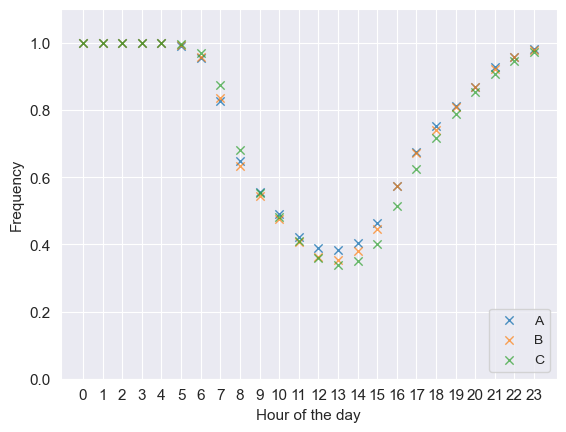

In [36]:
plt.scatter(range(0,24), df_survey_tempo.loc['A', :].values.tolist(), label='A', marker='x', alpha=0.8,linewidths=1)
plt.scatter(range(0,24), df_survey_tempo.loc['B', :].values.tolist(), label='B', marker='x', alpha=0.7,linewidths=1)
plt.scatter(range(0,24), df_survey_tempo.loc['C', :].values.tolist(), label='C', marker='x', alpha=0.7,linewidths=1)
plt.xlabel('Hour of the day', fontsize=11)
plt.ylabel('Frequency', fontsize=11)

x_labels = range(0, 24)  # Generate labels from 1 to 24
x_ticks = range(0, 24, 1)  # Position the labels every other data point
plt.ylim(0, 1.1)
plt.xticks(x_ticks, x_labels, fontsize=11)
plt.yticks(fontsize=11)
plt.legend(fontsize=10, frameon=True, loc='lower right')
#plt.savefig('figures/temporal_visitation_pattern'+urban_density_level+'.png', dpi=300, bbox_inches="tight")
plt.show()